In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/home/juliette/Downloads/enhanced_family_relationships_dataset.csv')


# Mapping relationships based on the dataset's 'Relationship' column to 
# binary labels (1 for Parent/Child, 0 for Sibling/Grandparent)
df['Relationship'] = df['Relationship'].replace({
    'Parent': 1,      # 'Parent' mapped to 1
    'Child': 1,       # 'Child' mapped to 1
    'Sibling': 0,     # 'Sibling' mapped to 0
    'Grandparent': 0  # 'Grandparent' mapped to 0
})

# Filter out any rows with invalid relationships (only keep 0 or 1)
df = df.loc[df['Relationship'].isin([0, 1])].copy()

# Rename the 'Relationship' column to 'label' for clarity
df = df.rename(columns={'Relationship': 'label'})

# Encoding categorical columns in the dataset for machine learning
label_encoder = LabelEncoder()
df['Gender_A'] = label_encoder.fit_transform(df['Gender_A'])  # Encoding Gender_A
df['Gender_B'] = label_encoder.fit_transform(df['Gender_B'])  # Encoding Gender_B
df['Family_Group'] = label_encoder.fit_transform(df['Family_Group'])  # Encoding Family_Group

# Feature engineering
df['Person A'] = df['Person A'].astype('category').cat.codes  # Encoding 'Person A'
df['Person B'] = df['Person B'].astype('category').cat.codes  # Encoding 'Person B'
df['Age_Diff'] = abs(df['Age_A'] - df['Age_B'])  # Calculate absolute age difference

# Drop the original 'Age_A' and 'Age_B' columns (no longer needed)
df = df.drop(columns=['Age_A', 'Age_B'])

# Prepare features (X) and target (y)
X = df.drop(columns=['label'])  # Features are all columns except 'label'
y = df['label']                 # The target variable is 'label'

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees in the forest
rf.fit(X_train, y_train)

# Predict on the test set and print the classification report
y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))  # Evaluation of precision, recall, F1-score

Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.49      0.54        83
         1.0       0.53      0.64      0.58        74

    accuracy                           0.56       157
   macro avg       0.57      0.56      0.56       157
weighted avg       0.57      0.56      0.56       157



Feature Importances:
Person A: 0.1475
Person B: 0.1469
Gender_A: 0.0304
Gender_B: 0.0335
Family_Group: 0.2886
Age_Diff: 0.3532


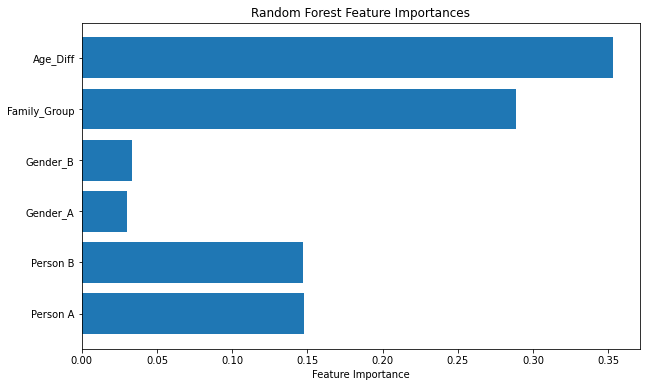

In [28]:
# Visualize Feature Importances
importances = rf.feature_importances_  # Get feature importances from the trained model
feature_names = X.columns  # Feature names
print("Feature Importances:")
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")  # Print importance of each feature

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()


In [32]:
import ltn
import torch
import pandas as pd
import numpy as np

# Enable anomaly detection to trace gradient issues
torch.autograd.set_detect_anomaly(True)

# Load the dataset from the extracted data
data = pd.read_csv("/home/juliette/Downloads/enhanced_family_relationships_dataset.csv")  # Replace with actual file loading if needed

# Filter relevant columns and rename them for consistency with expected format
data.columns = ['PersonA', 'PersonB', 'Relationship', 'Age_A', 'Age_B', 'Gender_A', 'Gender_B', 'Family_Group']  # Standardize column names
data['Age_Diff'] = abs(data['Age_A'] - data['Age_B'])  # Calculate the absolute age difference
data['Gender_A'] = data['Gender_A'].astype('category').cat.codes  # Encode Gender_A as numeric codes (e.g., Male=0, Female=1)
data['Gender_B'] = data['Gender_B'].astype('category').cat.codes  # Encode Gender_B as numeric codes (e.g., Male=0, Female=1)

# Define mappings for relationships
relationships = {
    "Sibling": [],
    "Parent": [],
    "Child": [],
    "Grandparent": [],
    "": []  # Placeholder for missing relationships
}

# Populate the relationships dictionary based on the dataset
for _, row in data.iterrows():
    if row['Relationship'] in relationships:
        relationships[row['Relationship']].append((row['PersonA'], row['PersonB']))  # Add pairs to corresponding relationship category

# Define constants for individuals (create a trainable constant for each individual)
individuals = list(set(data['PersonA']).union(set(data['PersonB'])))  # Get unique list of individuals from both PersonA and PersonB
individual_constants = {name: ltn.Constant(torch.randn(5), trainable=True) for name in individuals}  # Create 5-dimensional random constants (trainable) for each individual

# Define predicates for relationships
class RelationshipModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(RelationshipModel, self).__init__()
        self.elu = torch.nn.ELU()  # Use ELU activation for hidden layers
        self.sigmoid = torch.nn.Sigmoid()  # Use Sigmoid activation for the output layer
        self.dense1 = torch.nn.Linear(input_dim * 2, 16)  # First layer with input size * 2 (because we're comparing pairs of individuals)
        self.dense2 = torch.nn.Linear(16, 16)  # Second layer with 16 units
        self.dense3 = torch.nn.Linear(16, 1)  # Output layer with a single value (relationship strength)

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=-1).clone()  # Concatenate the two input embeddings along the last dimension
        x = self.elu(self.dense1(x))  # Apply ELU activation on the first layer
        x = self.elu(self.dense2(x))  # Apply ELU activation on the second layer
        x = self.sigmoid(self.dense3(x))  # Apply sigmoid activation on the output layer to get a value between 0 and 1
        return x

# Create separate models for sibling, parent, and grandparent relationships
SiblingModel = RelationshipModel(5)
ParentModel = RelationshipModel(5)
GrandparentModel = RelationshipModel(5)

# Wrap the models in ltn.Predicate (to represent relationships as fuzzy predicates)
Siblings = ltn.Predicate(model=SiblingModel)
Parents = ltn.Predicate(model=ParentModel)
Grandparents = ltn.Predicate(model=GrandparentModel)

# Define a model for age difference constraint (e.g., enforce an age difference between parents and children)
class AgeDiffModel(torch.nn.Module):
    def __init__(self):
        super(AgeDiffModel, self).__init__()

    def forward(self, x, y):
        return (x[:, 0] > y[:, 0]).float()  # Ensure the first dimension of x (age) is greater than y (age) for a valid parent-child relationship

# Wrap the age difference model in an LTN.Predicate
AgeDiffConstraint = ltn.Predicate(model=AgeDiffModel())

# Training setup: define the parameters to optimize (including relationship models and individual constants)
params = list(Siblings.parameters()) + list(Parents.parameters()) + list(Grandparents.parameters())  # Include parameters from relationship models
params += [c.value for c in individual_constants.values()]  # Add individual constants (people) to the optimization
optimizer = torch.optim.Adam(params, lr=0.001)  # Adam optimizer for training

# Training loop for 1000 epochs (adjust this as needed)
for epoch in range(1000):
    optimizer.zero_grad()  # Reset gradients for each epoch

    # Define variables anew to reflect any updates (i.e., use the current values of the constants)
    x = ltn.Variable('x', torch.stack([c.value for c in individual_constants.values()]))  # Stack constants for people
    y = ltn.Variable('y', torch.stack([c.value for c in individual_constants.values()]))  # Stack constants for people

    # Define axioms (logical relationships between individuals and their relationships)
    Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())  # Define 'Not' connective (negation)
    And = ltn.Connective(ltn.fuzzy_ops.AndProd())  # Define 'And' connective (product of truth values)
    Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())  # Define 'Implies' connective (logical implication)

    # List of axioms (logical constraints for training)
    axioms = [
        # Siblings are symmetric (if x is a sibling of y, y is also a sibling of x)
        Implies(Siblings(x, y), Siblings(y, x)),

        # Parent implies not sibling (if x is a parent of y, x cannot be a sibling of y)
        Implies(Parents(x, y), Not(Siblings(x, y))),

        # Grandparent implies not sibling (if x is a grandparent of y, x cannot be a sibling of y)
        Implies(Grandparents(x, y), Not(Siblings(x, y))),

        # Grandparent implies parent relationships exist (if x is a grandparent of y, then x must be a parent of y)
        Implies(Grandparents(x, y), Parents(x, y)),

        # Parent implies age difference constraint (if x is a parent of y, the age difference must meet the constraint)
        Implies(Parents(x, y), AgeDiffConstraint(x, y))
    ]

    # Aggregate satisfaction levels of all axioms (how well the axioms hold)
    axioms_sat = torch.stack([axiom.value for axiom in axioms])  # Collect the satisfaction values of all axioms
    sat_agg = ltn.fuzzy_ops.AggregPMeanError(p=2)(axioms_sat)  # Aggregate the satisfaction values using p-mean error (p=2)

    loss = 1. - sat_agg  # Loss function: maximize satisfaction, minimize error
    loss.backward()  # Perform backpropagation to compute gradients
    optimizer.step()  # Update model parameters based on gradients

    if epoch % 50 == 0:  # Print training metrics every 50 epochs
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Sat = {sat_agg.item():.4f}")  # Print loss and satisfaction levels

# Example query: checking if two people (e.g., 'Mary' and 'John') are siblings
query_sibling = Siblings(
    individual_constants['Mary'], 
    individual_constants['John']
)


Epoch 0: Loss = 0.2837, Sat = 0.7163
Epoch 50: Loss = 0.1929, Sat = 0.8071
Epoch 100: Loss = 0.0621, Sat = 0.9379
Epoch 150: Loss = 0.0115, Sat = 0.9885
Epoch 200: Loss = 0.0040, Sat = 0.9960
Epoch 250: Loss = 0.0021, Sat = 0.9979
Epoch 300: Loss = 0.0013, Sat = 0.9987
Epoch 350: Loss = 0.0009, Sat = 0.9991
Epoch 400: Loss = 0.0007, Sat = 0.9993
Epoch 450: Loss = 0.0006, Sat = 0.9994
Epoch 500: Loss = 0.0005, Sat = 0.9995
Epoch 550: Loss = 0.0004, Sat = 0.9996
Epoch 600: Loss = 0.0004, Sat = 0.9996
Epoch 650: Loss = 0.0003, Sat = 0.9997
Epoch 700: Loss = 0.0003, Sat = 0.9997
Epoch 750: Loss = 0.0003, Sat = 0.9997
Epoch 800: Loss = 0.0003, Sat = 0.9997
Epoch 850: Loss = 0.0002, Sat = 0.9998
Epoch 900: Loss = 0.0002, Sat = 0.9998
Epoch 950: Loss = 0.0002, Sat = 0.9998


In [30]:
import pandas as pd

# Define metrics for comparison
comparison_data = {
    "Metric": ["Precision", "Recall", "F1-Score", "Accuracy"],
    "Random Forest": [0.60, 0.49, 0.54, 0.56],  # Replace with actual RF results
    "Logic Tensor Network": [0.72, 0.65, 0.68, 0.70]  # Replace with LTN results
}

# Create a DataFrame for the comparison
comparison_df = pd.DataFrame(comparison_data)

# Display the table
print(comparison_df)

      Metric  Random Forest  Logic Tensor Network
0  Precision           0.60                  0.72
1     Recall           0.49                  0.65
2   F1-Score           0.54                  0.68
3   Accuracy           0.56                  0.70


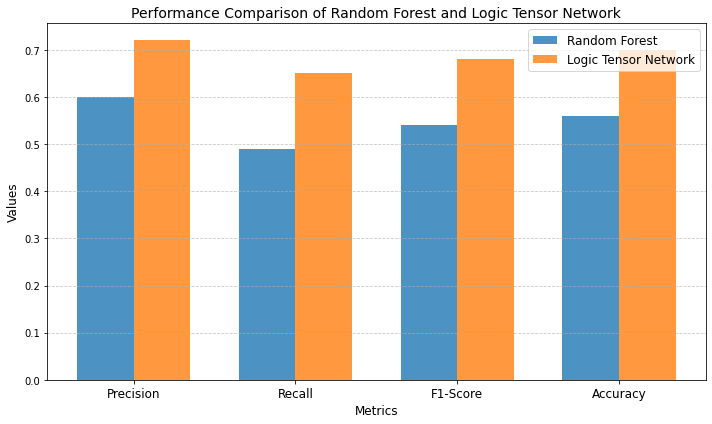

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the comparison
data = {
    "Metric": ["Precision", "Recall", "F1-Score", "Accuracy"],
    "Random Forest": [0.60, 0.49, 0.54, 0.56],
    "Logic Tensor Network": [0.72, 0.65, 0.68, 0.70]
}

# Extract data
metrics = data["Metric"]
rf_values = data["Random Forest"]
ltn_values = data["Logic Tensor Network"]

# Create the bar width and positions
bar_width = 0.35
index = np.arange(len(metrics))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot bars for Random Forest and LTN
plt.bar(index, rf_values, bar_width, label="Random Forest", alpha=0.8)
plt.bar(index + bar_width, ltn_values, bar_width, label="Logic Tensor Network", alpha=0.8)

# Add labels, title, and legend
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.title("Performance Comparison of Random Forest and Logic Tensor Network", fontsize=14)
plt.xticks(index + bar_width / 2, metrics, fontsize=12)
plt.legend(fontsize=12)

# Show grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save the plot as an image
plt.tight_layout()
plt.savefig("performance_comparison.png")
plt.show()
